In [18]:
import numpy as np
import networkx as nx
import osmnx as ox
import yaml
import time

class RouteFinder:
    def __init__(self, **kwargs):
        self.pos = kwargs.get('pos', (50.291100737108025, 18.680043199195698))
        self.dist = kwargs.get('dist', 2000.0)
        self.bike_type  = kwargs.get('bike_type', 'Recumbent')
        # Load bike_types
        with open('bike_types.yaml', 'r') as file:
            self.bike_types = yaml.safe_load(file)
        
        # Create graph from ox
        ox.settings.useful_tags_way+=['cycleway', 'surface']
        self.G = ox.graph.graph_from_point(self.pos, dist=self.dist, network_type="bike")
        self.G = ox.project_graph(self.G, to_latlong=True)

        # Set starting node = initial pos
        self.starting_pos = self.nearest_nodes(self.pos)

        # Distance function
        self.dist_func = lambda a, b :  ox.distance.great_circle(lat1=self.G.nodes[a]['y'],
                                lon1=self.G.nodes[a]['x'],
                                lat2=self.G.nodes[b]['y'],
                                lon2=self.G.nodes[b]['x']
                                )

        # # Weight functions
        # # Jak najbardziej, przydałoby się to opakowac jako zwykłe metody... too bad!
        # self.weight_func = lambda u, v, d: self.bike_types[self.bike_type][ d["surface"] ] if "surface" in d.keys() else 1.0
        # self.weight_func_dist = lambda u, v, d: self.weight_func(u, v, d) * d["length"] if "length" in d.keys() else 10.0
        # self.weight_func_back = lambda u, v, d: self.weight_func_dist(u, v, d) + float('inf') if (d["visited"]==True if "visited" in d.keys() else False) else self.weight_func_dist(u, v, d)
        # # self.weight_func_back = lambda u, v, d: self.weight_func_dist(u, v, d)*3.0 if d[self.key]["visited"]==True else self.weight_func_dist(u, v, d)

        # Weight functions
        # Jak najbardziej, przydałoby się to opakowac jako zwykłe metody... too bad!
                
        # self.weight_func = lambda u, v, d: self.bike_types[self.bike_type][ d["surface"] ] if "surface" in d.keys() else 1.0
        # self.weight_func_dist = lambda u, v, d: self.weight_func(u, v, d) * d["length"] if "length" in d.keys() else 10.0
        # self.weight_func_back = lambda u, v, d: self.weight_func_dist(u, v, d) + float('inf') if (d["visited"]==True if "visited" in d.keys() else False) else self.weight_func_dist(u, v, d)
        # self.weight_func_back = lambda u, v, d: self.weight_func_dist(u, v, d)*3.0 if d[self.key]["visited"]==True else self.weight_func_dist(u, v, d)

    def get_weight_func(self):
            def weight_func(u, v, d):
                if "surface" in d.keys():
                    return self.get_edge_surface_weight(d["surface"])
                else:
                    return 1.0
            return weight_func
                
    def get_weight_func_dist(self):
        def weight_func_dist(u, v, d):
            if "length" in d.keys():
                # weight_func = self.get_weight_func()
                return self.get_weight_func()(u, v, d) * d["length"]
            else:
                return 10.0
        return weight_func_dist
                
    def get_weight_func_back(self):
        def weight_func_back(u, v, d):
            if "visited" in d.keys():
                if d["visited"]==True:
                    return self.get_weight_func_dist()(u, v, d) + float('inf')
                else:
                    return self.get_weight_func_dist()(u, v, d)
            else:
                return self.get_weight_func_dist()(u, v, d)
        return weight_func_back
    
    def get_edge_surface_weight(self, surface):
        road_type = None
        found = False
        for k, v in self.bike_types["Surfaces"].items():
            if found:
                break
            for el in v:
                if v == surface:
                    road_type = k
                    found = True
                    break
        if road_type == None:
            return 1.0
        else:
            return self.bike_types["BIkes"][self.bike_type][road_type]
        
        
    
    def make_route(self, distance, start=None, divisions = 5):
        ### init varaibles ###
        if start == None:
             start = self.starting_pos
        path = [start]
        part = distance/divisions # distance for the smaller parts of the route
        part_previous = part
        total_distance = 0
        acceptable_attemps = 0
        i = 0

        # Set visited to False
        visited_mapping = {(u, v, 0) : False for u, v, d in self.G.edges(data=True)}
        nx.set_edge_attributes(self.G, visited_mapping, "visited")

        # Set current start and finish
        a = start
        b = start
        previous = start

        ### "Going for a little walk, brb" part - loop start###
        while acceptable_attemps < 10:
            b = self.find_part(a, previous, part, part_previous)
            part_path = nx.astar_path(self.G, a, b, heuristic=self.dist_func, weight=self.get_weight_func_dist())
            part_distance = nx.path_weight(self.G, part_path, 'length')

            # Check path back from the found 'b' node:
            back_path = nx.astar_path(self.G, b, start, heuristic=self.dist_func, weight=self.get_weight_func_back())
            back_distance = nx.path_weight(self.G, back_path, 'length')

            # See if need to go back and what approach is better:
            if total_distance+part_distance+back_distance > distance*1.05:
                back_path_previous = nx.astar_path(self.G, a, start, heuristic=self.dist_func, weight=self.get_weight_func_back())
                back_distance_previous = nx.path_weight(self.G, back_path_previous, 'length')

                if total_distance+back_distance_previous > distance*0.95: # If previous solution is long enough
                    path += back_path_previous[1:]
                    total_distance = nx.path_weight(self.G, path, 'length')
                    return path, total_distance
                
                else: # If it is not, try with a smaller part
                    part /= 2
                    acceptable_attemps +=1
                    continue

            elif total_distance+part_distance+back_distance > distance*0.95: # if found solution is long enough, go back
                break

            # Otherwise, continue walk
            
            # Update state of nodes, path and algorithm:
            if i >= divisions:
                break
            part_previous = part
            i+=1
            # Mark visited
            for edge in range(0, len(part_path)-1, 1):
                self.G.edges[part_path[edge], part_path[edge+1], 0]['visited']=True
            path += part_path[1:]
            total_distance = nx.path_weight(self.G, path, 'length')
            previous = a
            a = b

        ### end of loop ###

        path += part_path[1:]
        path += back_path[1:]
        total_distance = nx.path_weight(self.G, path, 'length')
        return path, total_distance
    
    # def find_part(self, start, previous, distance, distance_previous):
    #     a = start
    #     best_b = a
    #     best_score = float('inf')

    #     # Run dijkastra
    #     dijkstra_distnaces, dijkstra_paths = nx.single_source_dijkstra(self.G, a, weight=self.weight_func_dist, cutoff=distance)
    #     for k, v in dijkstra_distnaces.items():
    #         d = self.dist_func(a, k) # Distance between 'a' node and inspected node
    #         d_prev = self.dist_func(previous, k) # Distance between 'previous' node and inspected node
    #         score = (d-distance)**2 + (d_prev-distance_previous)**2 # Calculate MSE
    #         if score < best_score:
    #             best_score = score
    #             best_b = k
    #     return best_b

    # sorted(range(len(a)), key=lambda i: a[i])[-2:]

    # def find_part(self, start, previous, distance, distance_previous):
    #     a = start
    #     # best_b = a
    #     # best_score = float('inf')

    #     # Run dijkastra
    #     # dijkstra_distnaces, dijkstra_paths = nx.single_source_dijkstra(self.G, a, weight=self.weight_func_dist, cutoff=distance)
    #     dijkstra_distnaces, _ = nx.single_source_dijkstra(self.G, a, weight=self.weight_func_dist, cutoff=distance)
    #     # dd = dijkstra_distnaces.values()
    #     possible_nodes = sorted(dijkstra_distnaces.keys(), key=lambda k: (self.dist_func(a, k)-distance)**2 + (self.dist_func(previous, k)-distance_previous)**2 )[:10]
        
    #     b = np.random.choice(possible_nodes, size=1)[0]
    #     return b
    
    def find_part(self, start, previous, distance, distance_previous):
        a = start
        # best_b = a
        # best_score = float('inf')

        # Run dijkastra
        # dijkstra_distnaces, dijkstra_paths = nx.single_source_dijkstra(self.G, a, weight=self.weight_func_dist, cutoff=distance)
        dijkstra_distnaces, _ = nx.single_source_dijkstra(self.G, a, weight=self.get_weight_func_dist(), cutoff=distance)
        # dd = dijkstra_distnaces.values()
        # possible_nodes = sorted(dijkstra_distnaces.keys(), key=lambda k: (self.dist_func(a, k)-distance)**2 + (self.dist_func(previous, k)-distance_previous)**2 )[:10]
        possible_nodes = np.fromiter(dijkstra_distnaces.keys(), dtype=np.int64)
        # print(possible_nodes)
        possible_scores = np.zeros_like(possible_nodes, dtype=np.float32)
        # i = 0
        for i, k  in enumerate(possible_nodes):
            d = self.dist_func(a, k) # Distance between 'a' node and inspected node
            d_prev = self.dist_func(previous, k) # Distance between 'previous' node and inspected node
            score = (d-distance)**2 + (d_prev-distance_previous)**2 # Calculate MSE
            possible_scores[i] = score
            # i+=1
        sorted_order = np.argsort(possible_scores)
        # print(possible_nodes[sorted_order[:5]], possible_scores[sorted_order[:5]])
        #     if score < best_score:
        #         best_score = score
        #         best_b = k
        # return best_b

        b = np.random.choice(possible_nodes[sorted_order[:10]], size=1)[0]
        return b
    
    def plot_graph(self, path):
        return ox.plot_graph_route(self.G, path)
    
    def nearest_nodes(self, pos=(50.291100737108025, 18.680043199195698)):
        return ox.nearest_nodes(self.G, Y=pos[0], X=pos[1])
    
    def nodes_to_cords(self, path):
        return [[self.G.nodes[el]['y'], self.G.nodes[el]['x']] for el in path]

In [19]:
dist = 2000

start_t = time.time()
rf = RouteFinder(
    pos=(50.291100737108025, 18.680043199195698),
    dist = dist,
    bike_type = 'Recumbent'
)
end_t = time.time()
print(f"Elapsed time for loading map of dist: {dist} was: {end_t-start_t:.2f}s")

a = rf.nearest_nodes(pos=(50.291100737108025, 18.680043199195698))

Elapsed time for loading map of dist: 2000 was: 2.47s


Total distance: 5039.4659999999985


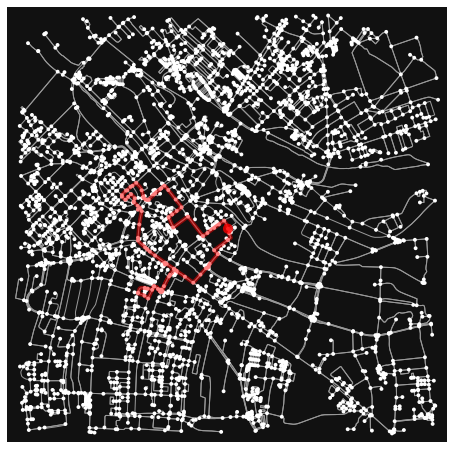

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [39]:
length = 5000
p1, l1 =  rf.make_route(length)
print(f"Total distance: {l1}")
rf.plot_graph(path=p1)